# 1.Import Thư viện

In [1]:
#các thư viện hỗ trợ
import yfinance as yf #load dữ liệu
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import datetime #lấy ngày
import matplotlib.pyplot as plt #vẽ biểu đồ
import pickle # lưu model
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình
from sklearn.model_selection import train_test_split #chia dữ liệu
from sklearn.model_selection import GridSearchCV #tìm giá trị tham số tốt nhất
#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra
###scikit_learn
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,StackingRegressor
#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình
from sklearn.metrics import mean_squared_error #bình phương sai số trung bình


In [2]:
### Tạo liên kết tới drive
from google.colab import drive
drive.mount('/content/drive')
folder = '/content/drive/MyDrive/Đồ án ML-2024'

Mounted at /content/drive


#2.Đọc dữ liệu

In [3]:
# Load dữ liệu
symbol = 'VND=X'
data = yf.download(symbol, start='2020-01-01', end='2024-06-01')
# Xóa dòng "Volume" từ Dataset
data = data.drop(columns=["Volume"])
# Hiển thị dữ liệu
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close
Date,,,,,
2020-01-01,23171.000000,23171.0,23171.000000,23171.0,23171.0
2020-01-02,22835.800781,23171.0,22805.605469,23171.0,23171.0
2020-01-03,23171.000000,23171.0,22812.912109,23171.0,23171.0
2020-01-06,22744.150391,23171.0,22744.150391,23171.0,23171.0
2020-01-07,23171.000000,23171.0,22822.310547,23171.0,23171.0


In [4]:
# Save the data to a CSV file
csv_file_path = 'USDVND_data.csv'
data.to_csv(csv_file_path)

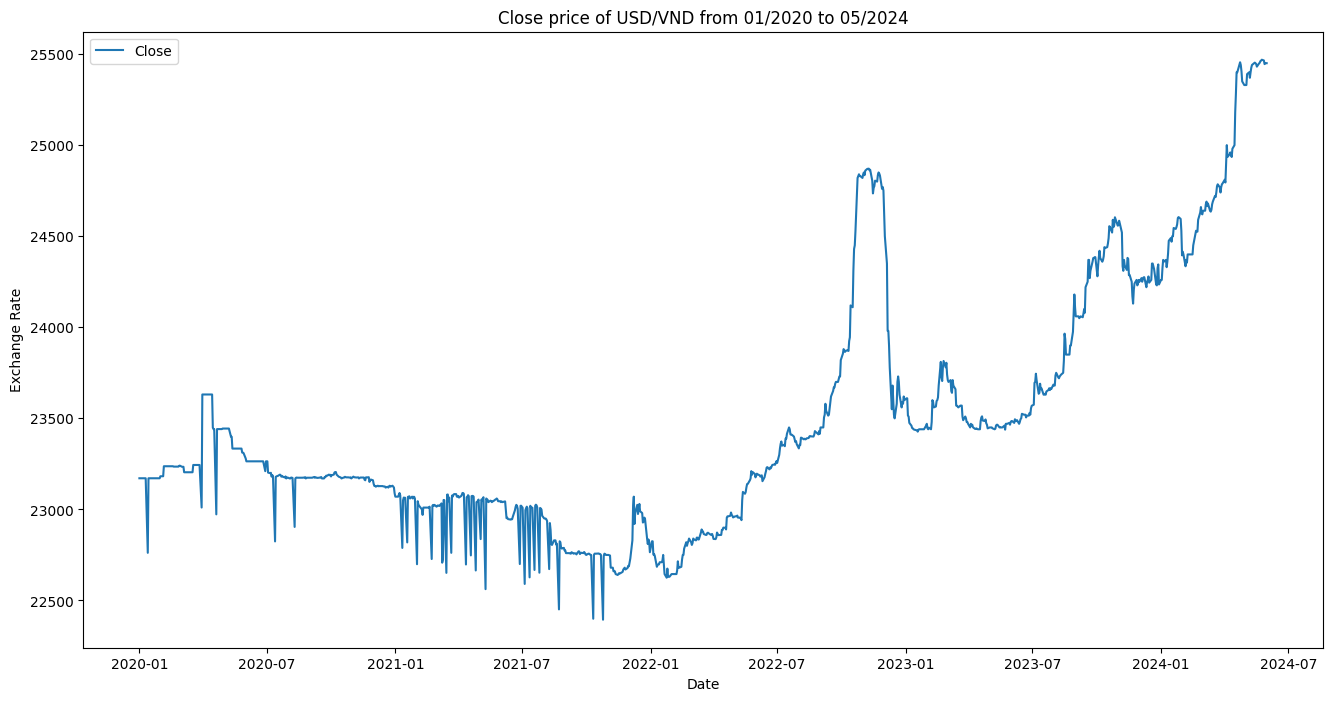

In [5]:
# Biểu đồ dữ liệu
plt.figure(figsize=(16,8))
plt.plot(data['Close'], label="Close")
plt.legend()
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Close price of USD/VND from 01/2020 to 05/2024')
# Hiển thị biểu đồ
plt.show()

#3.Phân tích dữ liệu

In [6]:
# Kích thước dữ liệu
data.shape

(1153, 5)

In [7]:
# Xác định kiểu dữ liệu
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1153 entries, 2020-01-01 to 2024-05-31
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1153 non-null   float64
 1   High       1153 non-null   float64
 2   Low        1153 non-null   float64
 3   Close      1153 non-null   float64
 4   Adj Close  1153 non-null   float64
dtypes: float64(5)
memory usage: 54.0 KB


In [8]:
# Mô tả bộ dữ liệu
data.describe()

,Open,High,Low,Close,Adj Close
count,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000
mean,23456.853937,23507.547207,23325.914489,23482.664427,23482.664427
std,687.911177,667.742012,747.517405,667.348072,667.348072
min,22298.406250,22645.000000,22260.353516,22394.345703,22394.345703
25%,22970.000000,23060.000000,22774.949219,23042.000000,23042.000000
50%,23237.000000,23262.195312,23014.000000,23244.000000,23244.000000
75%,23700.000000,23727.000000,23660.000000,23700.000000,23700.000000
max,25469.000000,25476.000000,25460.000000,25469.000000,25469.000000


# 4.Tiền xử lý dữ liệu

In [9]:
# Tạo dữ liệu tuần tự cho LSTM
def createSequentialData(data, window_size, future_days=0):
    X,y = [],[]
    for i in range(window_size, len(data)-future_days):
        X.append(data[i-window_size:i, 0])
        y.append(data[i+future_days, 0])
    X = np.array(X)
    y = np.array(y)
    return X.reshape(X.shape[0], X.shape[1], 1), y.reshape(-1, 1)

In [10]:
df=pd.DataFrame(data)
# Xác định features và target
features = ['Open', 'High', 'Low']
target = ['Close']

scaler = MinMaxScaler(feature_range=(0, 1))

# Chia dữ liệu thành 2 tập train_set và test_set
train_set, test_set = train_test_split(df, test_size=0.2, shuffle=False)
X_train, y_train = train_set[features], train_set[target]
X_test, y_test = test_set[features], test_set[target]

# Chuẩn hóa dữ liệu
# Train
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(y_train)
# Test
X_test_scaled = scaler.fit_transform(X_test)
y_test_scaled = scaler.fit_transform(y_test)

# Dữ liệu tuần tự cho LSTM
window_size = 10
X_seq, y_seq = createSequentialData(y_train_scaled, window_size)
X_testing, y_testing = createSequentialData(y_test_scaled, window_size)
y_testing = scaler.inverse_transform(y_testing)

#5.Xây dựng và huấn luyện mô hình

### Sử dụng các mô hình máy học thông thường



In [11]:
# Huấn luyện các base_models
# Linear Regression
linear = LinearRegression(fit_intercept = False)
linear.fit(X_train_scaled, y_train_scaled)
pickle.dump(linear, open(folder +'/save_model/linear_model.h5', 'wb'))
linear_pred = linear.predict(X_test_scaled) # Kết quả dự đoán
linear_pred = linear_pred.reshape(-1,1)
linear_pred = scaler.inverse_transform(linear_pred)
# Decision Tree Regression
decisionTree = DecisionTreeRegressor(max_depth=15, max_features=20)
decisionTree.fit(X_train_scaled, y_train_scaled)
pickle.dump(decisionTree, open(folder +'/save_model/decisiontree_model.h5', 'wb'))
decisionTree_pred = decisionTree.predict(X_test_scaled) #Kết quả dự đoán
decisionTree_pred = decisionTree_pred.reshape(-1,1)
decisionTree_pred = scaler.inverse_transform(decisionTree_pred)
# Random Forest Regression
randomForest = RandomForestRegressor(max_depth=15, n_estimators=80)
randomForest.fit(X_train_scaled, y_train_scaled.ravel())
pickle.dump(randomForest, open(folder +'/save_model/randomforest_model.h5', 'wb'))
randomForest_pred = randomForest.predict(X_test_scaled)
randomForest_pred = randomForest_pred.reshape(-1,1)
randomForest_pred = scaler.inverse_transform(randomForest_pred)


###Sử dụng Ensemble Learning

In [12]:
# Stacking Ensemble
# Khởi tạo các mô hình cơ bản
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(max_depth=15, max_features=20)),
    ('rf', RandomForestRegressor(max_depth=15, n_estimators=80))
]
# Khởi tạo mô hình meta
final_estimator = LinearRegression(fit_intercept = False)
# Tạo Stacking Regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=final_estimator)
stacking_regressor.fit(X_train_scaled, y_train_scaled)
pickle.dump(stacking_regressor, open(folder +'/save_model/stacking_model.h5', 'wb'))
# Đưa dự đoán
stacking_pred = stacking_regressor.predict(X_test_scaled)
stacking_pred = stacking_pred.reshape(-1,1)
stacking_pred = scaler.inverse_transform(stacking_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_stacking.py:957: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Sử dụng Deep Learning

In [13]:
# LSTM
lstm = Sequential()
lstm.add(LSTM(100, return_sequences=True, input_shape=(X_seq.shape[1], 1)))
lstm.add(LSTM(100))
lstm.add(Dropout(0.2))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.fit(X_seq, y_seq, epochs=50, batch_size=64)
pickle.dump(lstm, open(folder +'/save_model/lstm_model.h5', 'wb'))
lstm_pred = lstm.predict(X_testing)
lstm_pred = scaler.inverse_transform(lstm_pred)


Epoch 1/50
15/15 [==============================] - 6s 31ms/step - loss: 0.0435
Epoch 2/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0063
Epoch 3/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0033
Epoch 4/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0028
Epoch 5/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0028
Epoch 6/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0030
Epoch 7/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0033
Epoch 8/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0027
Epoch 9/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0026
Epoch 10/50
15/15 [==============================] - 0s 33ms/step - loss: 0.0025
Epoch 11/50
15/15 [==============================] - 0s 29ms/step - loss: 0.0027
Epoch 12/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0027
Epoch 13/50
15/15 [==================

##Trực quan hóa kết quả dự đoán

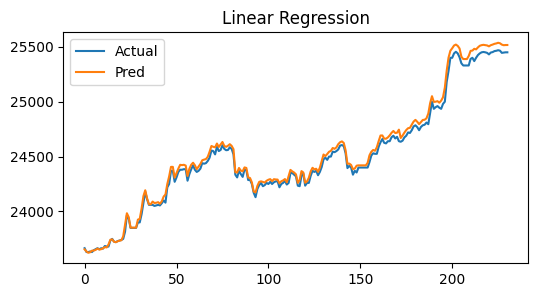

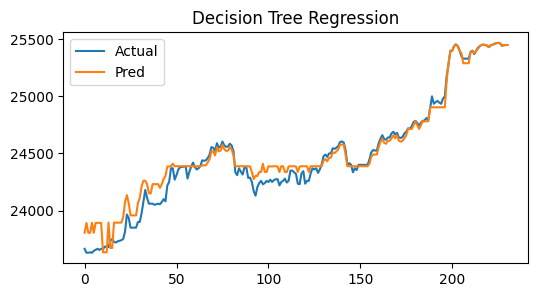

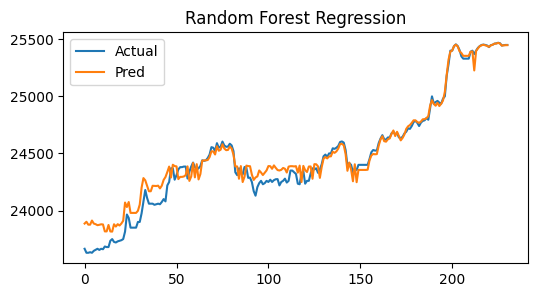

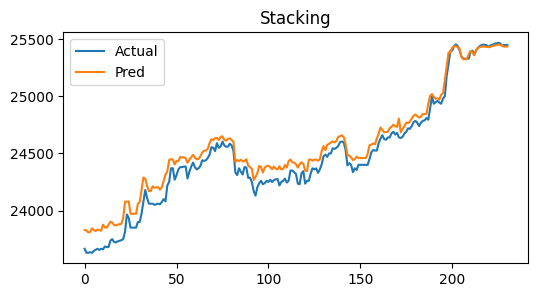

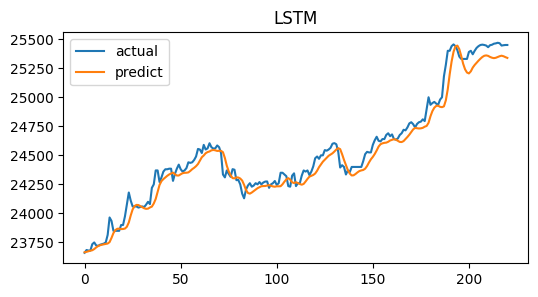

In [14]:
# Linear Regression
plt.figure(figsize=(6,3))
plt.title("Linear Regression")
plt.plot(y_test.values, label="Actual")
plt.plot(linear_pred, label="Pred")
plt.legend()

# Decision Tree Regression
plt.figure(figsize=(6,3))
plt.title("Decision Tree Regression")
plt.plot(y_test.values, label="Actual")
plt.plot(decisionTree_pred, label="Pred")
plt.legend()

# Random Forest Regression
plt.figure(figsize=(6,3))
plt.title("Random Forest Regression")
plt.plot(y_test.values, label="Actual")
plt.plot(randomForest_pred, label="Pred")
plt.legend()

# Ensemble Learning (Stacking)
plt.figure(figsize=(6,3))
plt.title("Stacking")
plt.plot(y_test.values, label="Actual")
plt.plot(stacking_pred, label="Pred")
plt.legend()

# LSTM
plt.figure(figsize=(6,3))
plt.title("LSTM")
plt.plot(y_testing, label="actual")
plt.plot(lstm_pred, label="predict")
plt.legend()

#6.Đánh giá mô hình


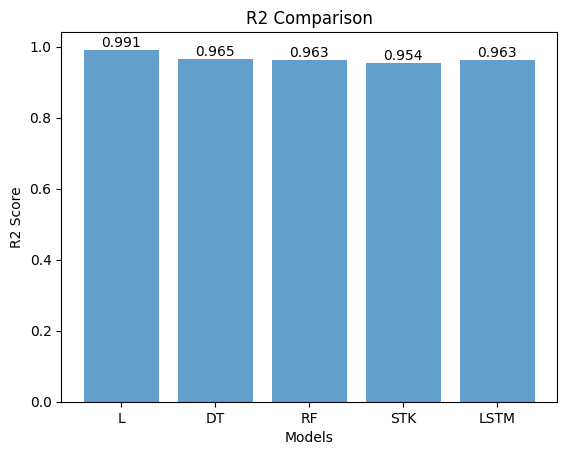


------------------------

R2
L: 0.9913343143107666
DT: 0.9650442240087627
RF: 0.9633989708614381
STK: 0.9541436087235737
LSTM: 0.9627521701593769

------------------------



In [15]:
predictions = [linear_pred, decisionTree_pred, randomForest_pred, stacking_pred]
model_labels = ["L", "DT", "RF", "STK","LSTM"]
# R2
r2 = []
for r in predictions:
  r2.append(r2_score(y_test, r))
r2.append(r2_score(y_testing, lstm_pred))
plt.title("R2 Comparison")
plt.bar(model_labels, r2, alpha=0.7, label='R2 of models')

for label, value in zip(model_labels, r2):
    plt.text(label, value, f'{value:.3f}', ha='center', va='bottom')
plt.title("R2 Comparison")
plt.xlabel("Models")
plt.ylabel("R2 Score")
plt.show()
print("\n------------------------\n")
print("R2")
for label, value in zip(model_labels, r2):
    print(f'{label}: {value}')
print("\n------------------------\n")

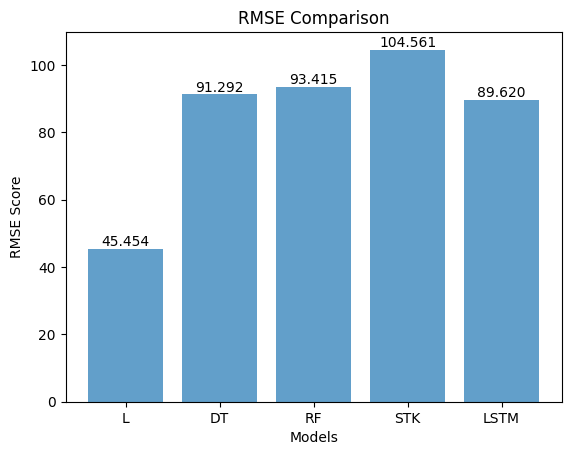


------------------------

RMSE
L: 45.45409083373241
DT: 91.29163451064048
RF: 93.41533112486424
STK: 104.56141367573731
LSTM: 89.62048293380164

------------------------



In [16]:
# RMSE
rmse = []
for r in predictions:
  rmse.append(np.sqrt(mean_squared_error(y_test, r)))
rmse.append(np.sqrt(mean_squared_error(y_testing, lstm_pred)))
plt.title("RMSE Comparison")
plt.bar(model_labels, rmse, alpha=0.7, label='RMSE of models')

for label, value in zip(model_labels, rmse):
    plt.text(label, value, f'{value:.3f}', ha='center', va='bottom')
plt.title("RMSE Comparison")
plt.xlabel("Models")
plt.ylabel("RMSE Score")
plt.show()
print("\n------------------------\n")
print("RMSE")
for label, value in zip(model_labels, rmse):
    print(f'{label}: {value}')
print("\n------------------------\n")

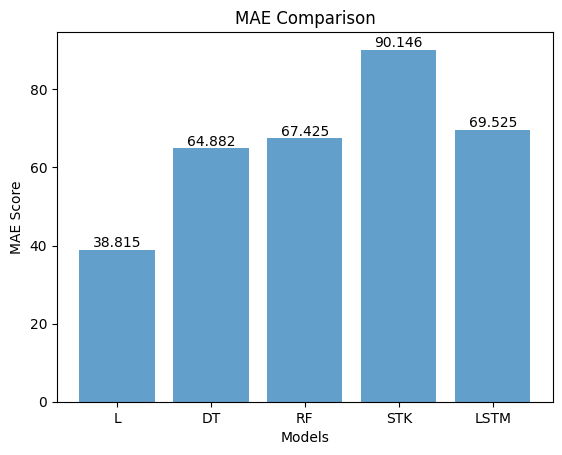


------------------------

MAE
L: 38.81533808892581
DT: 64.88176044603361
RF: 67.4248243047278
STK: 90.14591459667118
LSTM: 69.5249133908371

------------------------



In [17]:
# MAE
mae = []
for r in predictions:
  mae.append(mean_absolute_error(y_test, r))
mae.append(mean_absolute_error(y_testing, lstm_pred))
plt.title("MAE Comparison")
plt.bar(model_labels, mae, alpha=0.7)
for label, value in zip(model_labels, mae):
    plt.text(label, value, f'{value:.3f}', ha='center', va='bottom')
plt.title("MAE Comparison")
plt.xlabel("Models")
plt.ylabel("MAE Score")
plt.show()
print("\n------------------------\n")
print("MAE")
for label, value in zip(model_labels, mae):
    print(f'{label}: {value}')
print("\n------------------------\n")

#7.Đưa ra kết qua dự đoán tỷ giá trong tương lai

In [18]:
# Tạo dữ liệu huấn luyện
data_X = df[features]
data_y = df[target]
dates = df.index
last_input_date = dates[-1]
# Chuẩn hóa dữ liệu
data_X_scaled = scaler.fit_transform(data_X)
data_y_scaled = scaler.fit_transform(data_y)
# Tạo dữ liệu tuần tự
X_actual, y_actual = createSequentialData(data_y_scaled, window_size)
last_input_data = X_actual[-1:]
# Các biến để đưa ra dự đoán
future_days = 3 # Số ngày cần dự đoán trong tương lai
lookback = 30 #Số ngày dữ liệu trước đó cần dùng để tạo một cửa sổ dữ liệu đầu vào cho mô hình.

In [19]:
def predictRateInTheFuture(model_name, model):
  last_input_data = data_X_scaled[-lookback:] # lấy 30 phần tử cuối cùng
  last_input_date = dates[-1] # lấy ngày cuối cùng
  predicted_values = [] # lưu trử giá trị dự đoán
  forecasting_dates = [] # lưu trử ngày dự đoán
  for day in range(future_days):
    next_date = last_input_date + pd.DateOffset(days=day+1)
    forecasting_dates.append(next_date.strftime('%Y-%m-%d'));

    prediction = model.predict(last_input_data)
    prediction = scaler.inverse_transform(prediction.reshape(-1,1))
    predicted_values.append(prediction.flatten()[0])
    last_input_data = np.roll(last_input_data, -1, axis=0)

  predictions = pd.DataFrame(list(zip(forecasting_dates, predicted_values)), columns=['Date','Predict Close']) # Tạo dataframe mới chứa kết quả dự đoán và ngày

  print("Dự đoán tỷ giá hối đoái với",model_name, f'trong {future_days} ngày tiếp theo')
  print(predictions)

In [20]:
# LinearRegression
linear_2nd = LinearRegression(fit_intercept = False)
linear_2nd.fit(data_X_scaled, data_y_scaled)
predictRateInTheFuture("Linear Regression", linear_2nd)

Dự đoán tỷ giá hối đoái với Linear Regression trong 3 ngày tiếp theo
         Date  Predict Close
0  2024-06-01   25480.453268
1  2024-06-02   25489.715976
2  2024-06-03   25477.532472


In [21]:
# DecisionTree
decisionTree_2nd = DecisionTreeRegressor(max_depth=15, max_features=20)
decisionTree_2nd.fit(data_X_scaled, data_y_scaled)
predictRateInTheFuture('Decision Tree Regression', decisionTree_2nd)

Dự đoán tỷ giá hối đoái với Decision Tree Regression trong 3 ngày tiếp theo
         Date  Predict Close
0  2024-06-01        25440.0
1  2024-06-02        25455.0
2  2024-06-03        25440.0


In [22]:
# RandomForest
randomForest_2nd = RandomForestRegressor(max_depth=15, n_estimators=80)
randomForest_2nd.fit(data_X_scaled, data_y_scaled.ravel())
predictRateInTheFuture('Random Forest Regression', randomForest_2nd)

Dự đoán tỷ giá hối đoái với Random Forest Regression trong 3 ngày tiếp theo
         Date  Predict Close
0  2024-06-01     25440.5375
1  2024-06-02     25453.9750
2  2024-06-03     25433.6000


In [23]:
# Stacking
# Khởi tạo các mô hình cơ bản
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor()),
    ('rf', RandomForestRegressor())
]
# Khởi tạo mô hình meta
meta_model = LinearRegression()
# Khởi tạo Stacking Regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_regressor.fit(data_X_scaled, data_y_scaled.ravel())
predictRateInTheFuture('Stacking Regressor', stacking_regressor)

Dự đoán tỷ giá hối đoái với Stacking Regressor trong 3 ngày tiếp theo
         Date  Predict Close
0  2024-06-01   25430.205005
1  2024-06-02   25431.396784
2  2024-06-03   25422.857604


In [24]:
model_name = "LSTM"
lstm_2nd = Sequential()
lstm_2nd.add(LSTM(50, return_sequences=True, input_shape=(X_actual.shape[1], 1)))
lstm_2nd.add(LSTM(50))
lstm_2nd.add(Dropout(0.2))
lstm_2nd.add(Dense(1))
lstm_2nd.compile(optimizer='adam', loss='mean_squared_error')
lstm_2nd.fit(X_actual, y_actual, epochs=25, batch_size=32)

Epoch 1/25
36/36 [==============================] - 4s 11ms/step - loss: 0.0320
Epoch 2/25
36/36 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 3/25
36/36 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 4/25
36/36 [==============================] - 0s 11ms/step - loss: 0.0030
Epoch 5/25
36/36 [==============================] - 1s 17ms/step - loss: 0.0027
Epoch 6/25
36/36 [==============================] - 1s 17ms/step - loss: 0.0027
Epoch 7/25
36/36 [==============================] - 1s 18ms/step - loss: 0.0025
Epoch 8/25
36/36 [==============================] - 1s 17ms/step - loss: 0.0028
Epoch 9/25
36/36 [==============================] - 1s 16ms/step - loss: 0.0026
Epoch 10/25
36/36 [==============================] - 1s 17ms/step - loss: 0.0025
Epoch 11/25
36/36 [==============================] - 1s 19ms/step - loss: 0.0025
Epoch 12/25
36/36 [==============================] - 1s 17ms/step - loss: 0.0021
Epoch 13/25
36/36 [==================

In [25]:
# Tạo mảng chứa dữ liệu dự đoán và ngày
predicted_values = []
forecasting_dates = []
for day in range(future_days):
    next_date = last_input_date + pd.DateOffset(days=day+1)
    forecasting_dates.append(next_date.strftime('%Y-%m-%d'));
    predicted_price_scaled = lstm_2nd.predict(last_input_data) #lấy giá trị dự đoán từ LSTM
    # Update last_input_data
    last_input_data = np.roll(last_input_data, -1, axis=0)
    predicted_price_scaled = predicted_price_scaled[:, :, np.newaxis]
    last_input_data = np.concatenate([last_input_data[:, 1:, :], predicted_price_scaled], axis=1)
    predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))
    predicted_values.append(predicted_price[0, 0])

predictions = pd.DataFrame(list(zip(forecasting_dates, predicted_values)), columns=['Date','Predict Close'])

print("Dự đoán tỷ giá hối đoái với",model_name, f'trong {future_days} ngày')
print(predictions)

1/1 [==============================] - 0s 20ms/step
Dự đoán tỷ giá hối đoái với LSTM trong 3 ngày
         Date  Predict Close
0  2024-06-01   25452.960938
1  2024-06-02   25450.673828
2  2024-06-03   25448.958984
